In [1]:
import functools
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import os

@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
np.random.seed(0)

In [3]:
os.chdir('../../data')

In [4]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [5]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [6]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, "r").read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: "anime_id", 9: "my_score"}, axis=1)
    df["username"] = username
    df["anime_id"] = df["anime_id"].astype(int)
    df["my_score"] = df["my_score"].astype(int)
    df["username"] = df["username"].astype(str)
    df = df.loc[lambda x: x["my_score"] != 0]
    df = df.reset_index(drop=True)
    return df


def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x["username"] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [7]:
filtered_df = add_user(filtered_df, "user_profiles/Fro116.xml", "Fro116")

In [8]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [9]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [10]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [11]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on="anime_id")
    adj_cos_corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["normalized_score_x"], x["normalized_score_y"])
    )
    adj_cos_corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["normalized_score"], x["normalized_score"]))
    )
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame(
        (adj_cos_corr_numerator / adj_cos_corr_denom), columns=["corr"]
    )
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [12]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [13]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605473,0.605473
karthiga,59,7,0.040203,-0.059898,-0.474166,-0.474166
karthiga,74,7,0.316283,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227338,-0.059898,-0.206624,-0.206624


In [14]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, normalize_variance
):

    # Should we normalize by variance?
    # Note that normalize_variance=True modifies the data
    if normalize_variance:
        user_stds = (
            is_df.groupby("username")[["normalized_score"]]
            .std()
            .rename({"normalized_score": "user_std"}, axis=1)
        )
        is_df = is_df.merge(user_stds, on="username")
        is_df["normalized_score"] /= is_df["user_std"]
        is_df = is_df.drop("user_std", axis=1)

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.sort_values(by="similarity").dropna()
    corrs = corrs.drop(recommendee)  # makes insample score more meaningful

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (
            is_df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on="username")
        ).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "normalize_variance": normalize_variance,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [15]:
%%time
from tqdm import tqdm

recommendee = "Fro116"
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(len(filtered_df)) / np.log(base)) + 1)
] + [len(filtered_df)]
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies because setting normalize_variance=True modifies the data
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, True
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, False
        )
    )

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,256,6,-0.007109,-1.027193,-0.459558,-0.459558
Fro116,33161,8,0.598972,-1.027193,0.934361,0.934361
Fro116,2724,8,0.041059,-1.027193,1.492275,1.492275
Fro116,33206,6,0.604474,-1.027193,-1.071141,-1.071141
Fro116,16001,8,0.632340,-1.027193,0.900994,0.900994


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,16,7,0.598092,-1.027193,-0.064759,-0.064759
Fro116,431,6,1.143566,-1.027193,-1.610233,-1.610233
Fro116,12115,6,0.730296,-1.027193,-1.196963,-1.196963
Fro116,218,6,0.060687,-1.027193,-0.527354,-0.527354
Fro116,396,9,0.347029,-1.027193,2.186304,2.186304


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,22687,6,-0.733812,-1.027193,0.267145,0.267145
Fro116,15617,5,-0.278302,-1.027193,-1.188365,-1.188365
Fro116,82,8,0.281751,-1.027193,1.251582,1.251582
Fro116,10162,7,1.082352,-1.027193,-0.549019,-0.549019
Fro116,5630,5,0.605685,-1.027193,-2.072352,-2.072352


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,35557,8,0.771315,-1.027193,0.762018,0.762018
Fro116,2924,5,0.642192,-1.027193,-2.108858,-2.108858
Fro116,879,6,-0.073983,-1.027193,-0.392684,-0.392684
Fro116,35838,8,0.483119,-1.027193,1.050215,1.050215
Fro116,5196,6,-0.278285,-1.027193,-0.188381,-0.188381


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,35851,4,0.682818,-1.027193,-3.149485,-3.149485
Fro116,1889,6,0.949183,-1.027193,-1.415850,-1.415850
Fro116,12113,5,0.457188,-1.027193,-1.923855,-1.923855
Fro116,9760,6,0.210068,-1.027193,-0.676735,-0.676735
Fro116,40591,7,-0.493860,-1.027193,1.027193,1.027193


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,36539,7,-0.352044,-1.027193,0.885378,0.885378
Fro116,14813,9,0.507691,-1.027193,2.025642,2.025642
Fro116,22101,6,0.185061,-1.027193,-0.651728,-0.651728
Fro116,160,6,0.233831,-1.027193,-0.700498,-0.700498
Fro116,11843,6,0.757073,-1.027193,-1.223739,-1.223739


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,33489,7,0.534100,-1.027193,-0.000766,-0.000766
Fro116,6114,6,0.962570,-1.027193,-1.429237,-1.429237
Fro116,490,6,-0.058828,-1.027193,-0.407839,-0.407839
Fro116,1033,5,0.806017,-1.027193,-2.272683,-2.272683
Fro116,25519,9,-0.130003,-1.027193,2.663336,2.663336


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,8769,8,-0.013330,-1.027193,1.546663,1.546663
Fro116,2034,5,0.701908,-1.027193,-2.168574,-2.168574
Fro116,5081,5,0.825437,-1.027193,-2.292104,-2.292104
Fro116,24629,6,-0.792416,-1.027193,0.325750,0.325750
Fro116,31764,5,0.235046,-1.027193,-1.701713,-1.701713


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9055,7,-0.259060,-1.027193,0.792394,0.792394
Fro116,15911,5,-0.176364,-1.027193,-1.290303,-1.290303
Fro116,16664,8,0.760470,-1.027193,0.772864,0.772864
Fro116,189,6,-0.281496,-1.027193,-0.185171,-0.185171
Fro116,81,7,0.565557,-1.027193,-0.032224,-0.032224


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,24765,8,0.028793,-1.027193,1.504540,1.504540
Fro116,37171,5,-2.493860,-1.027193,1.027193,1.027193
Fro116,6547,6,0.811402,-1.027193,-1.278069,-1.278069
Fro116,31043,8,0.939692,-1.027193,0.593641,0.593641
Fro116,7645,7,0.273471,-1.027193,0.259863,0.259863


100%|██████████| 10/10 [13:41:25<00:00, 4928.50s/it]  

CPU times: user 5h 41min 1s, sys: 1h 20min 10s, total: 7h 1min 12s
Wall time: 13h 41min 26s


In [16]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [17]:
allerrors

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
0,0.008902,1.592626,1.0,1.0,0.000000,1.514802
1,0.008902,1.592626,1.0,1.0,0.000000,1.514802
2,0.100890,1.556016,2.0,1.0,0.105263,1.447602
3,0.100890,1.556016,2.0,1.0,0.105263,1.447602
4,0.130564,1.535412,4.0,1.0,0.105263,1.446347
...,...,...,...,...,...,...
1035,0.923077,0.798318,11863283.0,0.0,0.891892,1.852014
1036,0.923077,0.798318,16777216.0,0.0,0.891892,1.852014
1037,0.923077,0.798318,23726566.0,0.0,0.891892,1.852014
1038,0.923077,0.798318,33554432.0,0.0,0.891892,1.852014


In [18]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "normalize_variance"])

In [19]:
wide_data.loc[lambda x: x.normalize_variance == True, "variable"] = (
    "normalized_" + wide_data.loc[lambda x: x.normalize_variance == True, "variable"]
)

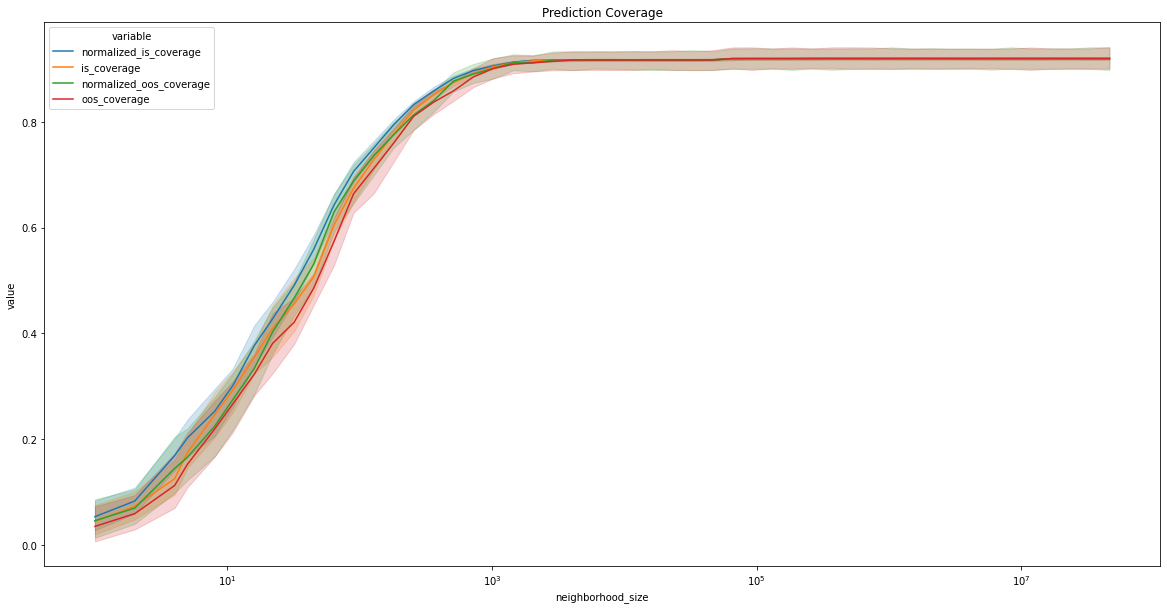

In [20]:
plt.figure(figsize=(20,10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

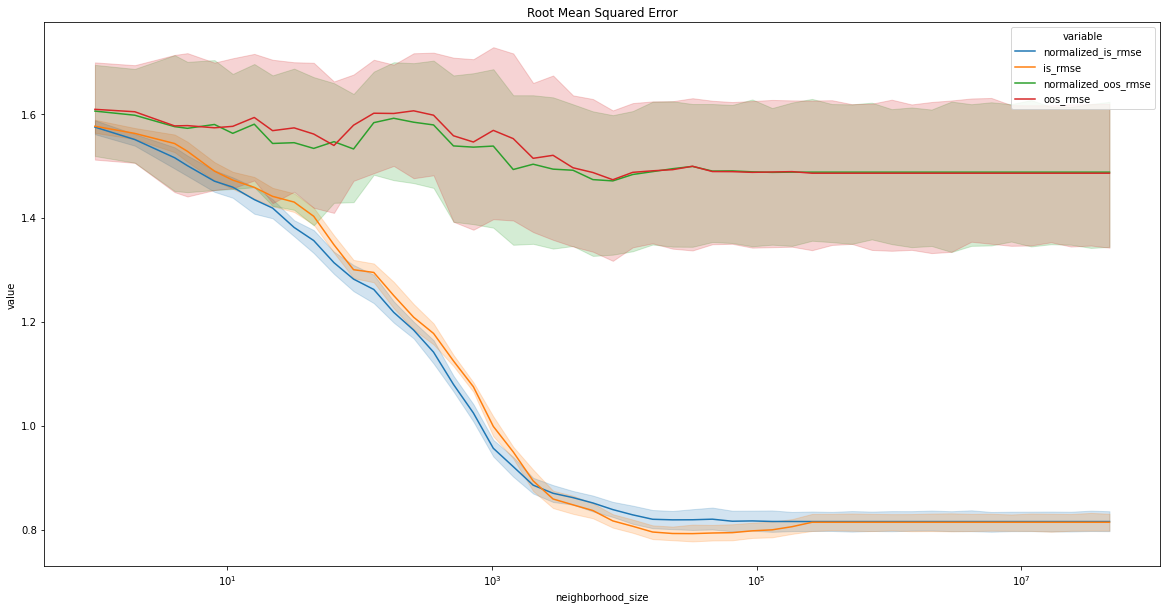

In [21]:
plt.figure(figsize=(20,10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
normalize_variance neighborhood_size                                               
1.0                8192.0                0.917332  0.838373      0.917212  1.470940
0.0                8192.0                0.917332  0.816594      0.917212  1.473183
1.0                5792.0                0.917332  0.851101      0.917212  1.473428
                   11585.0               0.917332  0.828222      0.917212  1.483254
0.0                741455.0              0.919999  0.813974      0.919915  1.485732
                   33554432.0            0.919999  0.813974      0.919915  1.485732
                   23726566.0            0.919999  0.813974      0.919915  1.485732
                   16777216.0            0.919999  0.813974      0.919915  1.485732
                   11863283.0            0.919999  0.813974      0.919915  1.485732
                   46358345.0            0.919999  0.813974      0.919915  1.485732

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance').sort_values(
    by="oos_rmse"
).head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
8192.0,0.917332,0.816594,0.917212,1.473183
23726566.0,0.919999,0.813974,0.919915,1.485732
16777216.0,0.919999,0.813974,0.919915,1.485732
11863283.0,0.919999,0.813974,0.919915,1.485732
8388608.0,0.919999,0.813974,0.919915,1.485732
5931641.0,0.919999,0.813974,0.919915,1.485732
4194304.0,0.919999,0.813974,0.919915,1.485732
2965820.0,0.919999,0.813974,0.919915,1.485732
2097152.0,0.919999,0.813974,0.919915,1.485732


In [25]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance').sort_values(
    by="is_rmse"
).head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
32768.0,0.917332,0.792136,0.917212,1.499135
23170.0,0.917332,0.792360,0.917212,1.492544
46340.0,0.917629,0.793321,0.917212,1.488936
65536.0,0.919407,0.794005,0.919915,1.488745
16384.0,0.917332,0.795195,0.917212,1.490354
92681.0,0.919703,0.797481,0.919915,1.487386
131072.0,0.919703,0.799438,0.919915,1.488055
185363.0,0.919703,0.805497,0.919915,1.488778
11585.0,0.917332,0.806252,0.917212,1.487409


In [26]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance')

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
1.0,0.044428,1.576150,0.034922,1.608652
2.0,0.072855,1.562344,0.059033,1.604007
4.0,0.125024,1.542851,0.112233,1.576779
5.0,0.174487,1.527879,0.152418,1.577335
8.0,0.245652,1.489753,0.218634,1.573134
11.0,0.292784,1.472488,0.266430,1.575948
16.0,0.354692,1.458498,0.322760,1.593009
22.0,0.409237,1.441203,0.381081,1.567636
32.0,0.455764,1.430178,0.421053,1.572985


In [27]:
allerrors.groupby(["normalize_variance", "neighborhood_size"]).apply(lambda x: np.sqrt(np.sum(x**2) / K)).xs(0, level='normalize_variance')

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
neighborhood_size,,,,,,
1.0,0.108687,2.229396,1.414214e+00,0.0,0.123700,2.294602
2.0,0.131939,2.209750,2.828427e+00,0.0,0.137536,2.287774
4.0,0.134799,1.543106,4.000000e+00,0.0,0.138245,1.591391
5.0,0.180922,1.528200,5.000000e+00,0.0,0.173165,1.593347
8.0,0.255535,1.490040,8.000000e+00,0.0,0.234284,1.586426
11.0,0.298961,1.472725,1.100000e+01,0.0,0.277623,1.589371
16.0,0.357818,1.458952,1.600000e+01,0.0,0.328639,1.605912
22.0,0.416475,1.441517,2.200000e+01,0.0,0.390817,1.582703
32.0,0.462609,1.430478,3.200000e+01,0.0,0.426934,1.586268
